<a href="https://colab.research.google.com/github/Faig22/TimeSeriesAnalysis/blob/main/energy_demand_hourly_brazil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np


from scipy.stats import norm, skew
from sklearn.model_selection import TimeSeriesSplit


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use('seaborn-bright')
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

In [ ]:
sns.color_palette()

[(0.0, 0.5607843137254902, 0.8352941176470589),
 (0.9882352941176471, 0.30980392156862746, 0.18823529411764706),
 (0.8980392156862745, 0.6823529411764706, 0.2196078431372549),
 (0.42745098039215684, 0.5647058823529412, 0.30980392156862746),
 (0.5450980392156862, 0.5450980392156862, 0.5450980392156862),
 (0.5058823529411764, 0.058823529411764705, 0.48627450980392156)]

## Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from zipfile import ZipFile

with ZipFile("drive/MyDrive/eletric energy.zip") as myzip:
    df = myzip.open("energy_demand_hourly_brazil.csv")

df = pd.read_csv(df)


Даннные представляют из себя потребление электроэнергии в Бразилии в течении 23 лет

In [ ]:
df.head()

,index,hourly_demand
0,2000-01-01 00:00:00,34673.9
1,2000-01-01 01:00:00,33503.0
2,2000-01-01 02:00:00,32287.6
3,2000-01-01 03:00:00,31059.4
4,2000-01-01 04:00:00,30272.7


In [ ]:
print(f"data shape:{df.shape}")

data shape:(201318, 2)


## Time Series Analysis

Посмотрим на пропущенные значения в данных

In [ ]:
missing_train = (df.isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)
missing_train = missing_train[missing_train > 0]
missing_train

Series([], dtype: float64)

Пропусков нет

In [ ]:
df.sample(5)

,index,hourly_demand
44536,2005-01-29 21:00:00,51171.780000
56497,2006-06-12 07:00:00,44835.200000
3329,2000-05-18 17:00:00,48729.700000
176959,2020-03-22 02:00:00,54284.515000
183202,2020-12-07 05:00:00,56275.683035


In [ ]:
df = df.rename(columns={"index": "datetime"})
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.set_index("datetime")

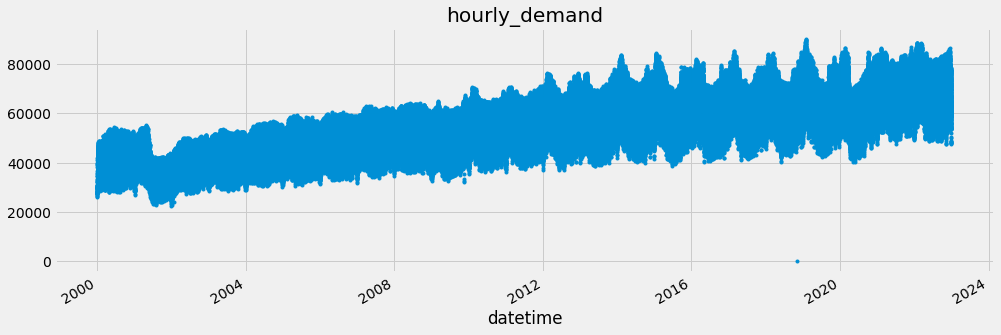

In [ ]:
df['hourly_demand'].plot(figsize = (15, 5), color = color_pal[0], title = 'hourly_demand', style ='.')
plt.show()

Данные носят сезонный характер, также присутствуют выброс в районе 2018 - 2019 годов 

In [ ]:
# df['hourly_demand'].plot(kind='hist', bins=500)
# plt.show()

In [ ]:
df.query('hourly_demand < 20000')

,hourly_demand
datetime,
2018-11-04,0.0


*2018-11-04* нет информации о потреблении энергии, поэтому удалим данную строку, она не несет никакой информации

In [ ]:
df = df.query('hourly_demand >= 20000').copy()

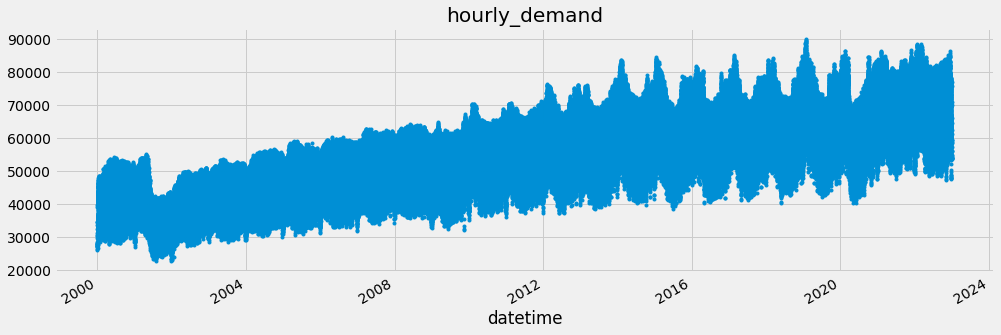

In [ ]:
df['hourly_demand'].plot(figsize = (15, 5), color = color_pal[0], title = 'hourly_demand', style ='.')
plt.show()

### Train Test Split

Рассмотрим два варианта разбивки данных на трейн и тест

Первый вариант. Разобьем данные на трейн и тест и установим границу на 01.01.2022

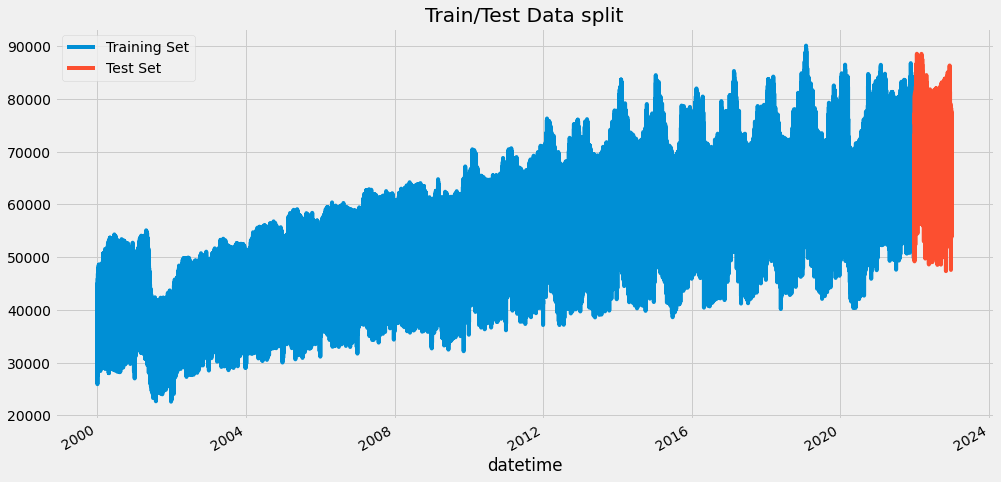

In [ ]:
df = df.sort_index()
train = df.loc[df.index < '2022-01-01']
test = df.loc[df.index >= '2022-01-01']

fig, ax = plt.subplots(figsize = (15, 8))


train.plot(ax=ax, title = 'Train/Test Data split')
test.plot(ax=ax)


ax.legend(['Training Set', 'Test Set'])
plt.show()




### Time Series Cross Validation

Теперь реализуем второй вариант, где будем кроссвалидировать временные данные (обязательно данные должны быть последовательны, чтобы при обучении модель не использовала данные из будущего при предсказании прошлого). Сделаем это через метод ***TimeSeriesSplit*** из библиотеки ***sklearn.model_selection***

In [ ]:
N_SPLITS = 5
GAP = 0
TEST_SIZE = 24*365*2 


tscv = TimeSeriesSplit(n_splits=N_SPLITS, gap = GAP, test_size = TEST_SIZE)
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=17520)


Проиллюстрируем разбивку данных

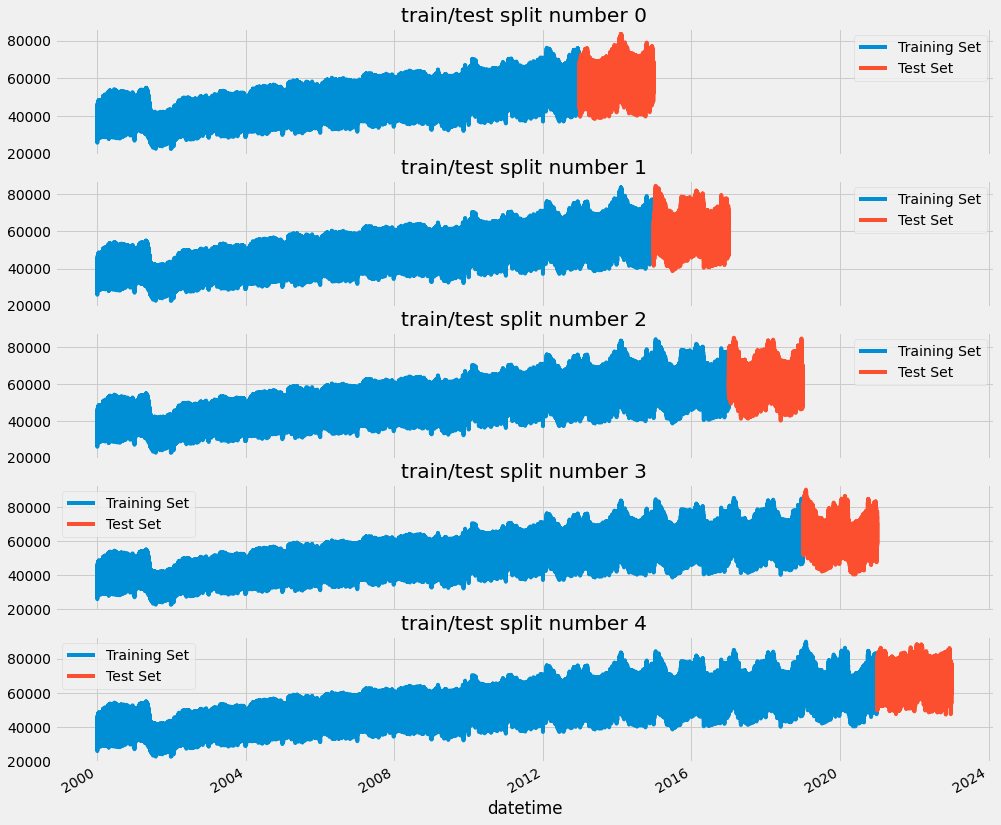

In [ ]:
fig, ax = plt.subplots(nrows=N_SPLITS, ncols=1, figsize=(15, 15), sharex=True)

for i, (train_index, test_index) in enumerate(tscv.split(df)):
    train_cv = df.iloc[train_index]
    test_cv = df.iloc[test_index]

    train_cv.plot(ax=ax[i], title=f'train/test split number {i}')
    test_cv.plot(ax=ax[i])

    ax[i].legend(['Training Set', 'Test Set'])



### Feature Engineering

Извлечем из данных год, месяц, день, часы, а также дни недели.

In [ ]:
def create_columns(df):
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['weekday'] = df.index.weekday

    return df



### Lag Features

Добавим еще пару признаков. Создадим столбцы, в которых будут содержаться значения электроэнергии ровно **364**, **728** дней назад. 

In [ ]:
df.columns

Index(['hourly_demand'], dtype='object')

Воспользуемся *pd.Timedelta()*, который позволяет вычитать период из столбца с временем 

In [ ]:
df.index - pd.Timedelta(1, 'h')

DatetimeIndex(['1999-12-31 23:00:00', '2000-01-01 00:00:00',
               '2000-01-01 01:00:00', '2000-01-01 02:00:00',
               '2000-01-01 03:00:00', '2000-01-01 04:00:00',
               '2000-01-01 05:00:00', '2000-01-01 06:00:00',
               '2000-01-01 07:00:00', '2000-01-01 08:00:00',
               ...
               '2022-12-31 14:00:00', '2022-12-31 15:00:00',
               '2022-12-31 16:00:00', '2022-12-31 17:00:00',
               '2022-12-31 18:00:00', '2022-12-31 19:00:00',
               '2022-12-31 20:00:00', '2022-12-31 21:00:00',
               '2022-12-31 22:00:00', '2022-12-31 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=201317, freq=None)

Пример того как работает представлен выше. Здесь был вычтен один час

Создаем несколько столбцов. Вычитаем именно 364 дня, а не 365, потому что 364 делится на 7, чтобы дни недели совпадали

In [ ]:
def create_lag_features(df):
    dict_of_target = df['hourly_demand'].to_dict()
    df['lag_1'] = (df.index - pd.Timedelta(364, 'd')).map(dict_of_target)
    df['lag_2'] = (df.index - pd.Timedelta(728, 'd')).map(dict_of_target)
    # df['lag_1'] = (df.index - pd.Timedelta(1092, 'd')).map(dict_of_target)
    # df['lag_1'] = (df.index - pd.Timedelta(1456, 'd')).map(dict_of_target)

    return df 

## Train with XGBoost

Обучим ***xgd.XGBRegressor*** сначала на стандартной разбивки данных, а потом на кросс-валидационном датасете

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

### Train Using Train Test Split

Обучим модель без ***Lag features*** и с ними

In [ ]:
train.head()

,hourly_demand
datetime,
2000-01-01 00:00:00,34673.9
2000-01-01 01:00:00,33503.0
2000-01-01 02:00:00,32287.6
2000-01-01 03:00:00,31059.4
2000-01-01 04:00:00,30272.7


In [ ]:
train_no_lag = create_columns(train) # Добавляем новые признаки в данные
test_no_lag = create_columns(test)


train_no_lag = train_no_lag[list(train_no_lag.columns)]
test_no_lag = test_no_lag[list(test_no_lag.columns)]


X_train_no_lag = train_no_lag.drop(columns = 'hourly_demand')
Y_train = train_no_lag['hourly_demand']

X_test_no_lag = test_no_lag.drop(columns = 'hourly_demand')
Y_test = test_no_lag['hourly_demand']

reg = xgb.XGBRegressor(max_depth=3, learning_rate=0.01, n_estimators = 1000)
reg.fit(X_train_no_lag, Y_train, verbose=50,
        early_stopping_rounds=50,
        eval_set=[(X_train_no_lag, Y_train), (X_test_no_lag, Y_test)])

Y_pred_no_lag = reg.predict(X_test_no_lag)
score = mean_squared_error(Y_test, Y_pred_no_lag)

<ipython-input-66-7d2ce7060b5e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
<ipython-input-66-7d2ce7060b5e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df.index.day
<ipython-input-66-7d2ce7060b5e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

[20:20:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:54504	validation_1-rmse:68703.5
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[50]	validation_0-rmse:33285.6	validation_1-rmse:44322.7
[100]	validation_0-rmse:20565.8	validation_1-rmse:29334.7
[150]	validation_0-rmse:13016.1	validation_1-rmse:19823.3
[200]	validation_0-rmse:8629.43	validation_1-rmse:13746.5
[250]	validation_0-rmse:6185.78	validation_1-rmse:9972.27
[300]	validation_0-rmse:4908.83	validation_1-rmse:7753.59
[350]	validation_0-rmse:4231.57	validation_1-rmse:6387.47
[400]	validation_0-rmse:3859.11	validation_1-rmse:5560.52
[450]	validation_0-rmse:3652.39	validation_1-rmse:5056
[500]	validation_0-rmse:3520.91	validation_1-rmse:4731.17
[550]	validation_0-rmse:3418.59	validation_1-rmse:4504.15
[600]	validation_0-rmse:33

In [ ]:

train_with_lag = create_lag_features(train_no_lag)
test_with_lag = create_lag_features(test_no_lag)


train_with_lag = train_with_lag[list(train_with_lag.columns)]
test_with_lag = test_with_lag[list(test_with_lag.columns)]

X_train_with_lag = train_with_lag.drop(columns = 'hourly_demand')
X_test_with_lag = test_with_lag.drop(columns = 'hourly_demand')


reg.fit(X_train_with_lag, Y_train, verbose=50,
        early_stopping_rounds=50,
        eval_set=[(X_train_with_lag, Y_train), (X_test_with_lag, Y_test)])

Y_pred_with_lag = reg.predict(X_test_with_lag)
score_with_lag = mean_squared_error(Y_test, Y_pred_with_lag)

[20:24:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:54501	validation_1-rmse:68907.2
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[50]	validation_0-rmse:33135.2	validation_1-rmse:52872.7
[100]	validation_0-rmse:20276.6	validation_1-rmse:43467.6
[150]	validation_0-rmse:12605.6	validation_1-rmse:37691.6
[200]	validation_0-rmse:8120.35	validation_1-rmse:33391.8
[250]	validation_0-rmse:5601.58	validation_1-rmse:29984.1
[300]	validation_0-rmse:4285.34	validation_1-rmse:27240.4
[350]	validation_0-rmse:3649.45	validation_1-rmse:24886.1
[400]	validation_0-rmse:3352.88	validation_1-rmse:23801
[450]	validation_0-rmse:3210.28	validation_1-rmse:22630.9
[500]	validation_0-rmse:3127.59	validation_1-rmse:21123
[550]	validation_0-rmse:3066.77	validation_1-rmse:20663.3
[600]	validation_0-rmse:301

Построим график распределения потребления электроэнергии от 01.12.2022 до 01.01.2023 и на этом графике изобразим предсказанные значения без ***Lag Features*** и с ними

<ipython-input-103-4053f7f505ed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred_no_lag'] = Y_pred_no_lag
<ipython-input-103-4053f7f505ed>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred_with_lag'] = Y_pred_with_lag


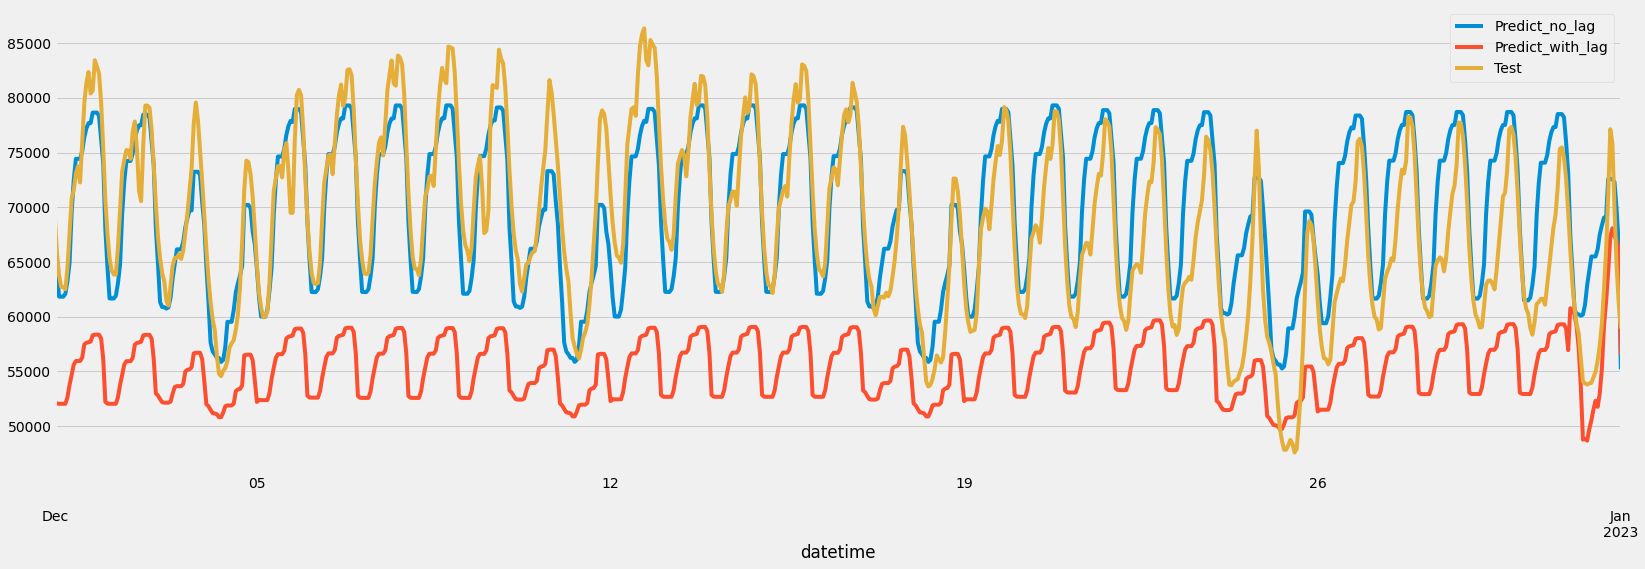

In [ ]:
df_test = df.loc[df.index >= '2022-01-01']
df_test['pred_no_lag'] = Y_pred_no_lag
df_test['pred_with_lag'] = Y_pred_with_lag
df_test = df_test.loc[df_test.index >= '2022-12-01']

fig, ax = plt.subplots(figsize = (25, 8))

df_test['pred_no_lag'].plot(ax=ax)
df_test['pred_with_lag'].plot(ax=ax)
df_test['hourly_demand'].plot(ax=ax)

ax.legend(['Predict_no_lag', 'Predict_with_lag','Test'])
plt.show()

**Вывод**: Обучение с данными из прошлых лет ухудшает прогноз, занижая значение таргета. Оставим данные без ***Lag Features***.

### Train Using Cross Validation

Теперь обучим модель на кросс валидации без данных за прошлое время

In [ ]:
N_SPLITS = 5
GAP = 0
TEST_SIZE = 24*365*2 


tscv = TimeSeriesSplit(n_splits=N_SPLITS, gap = GAP, test_size = TEST_SIZE)

In [ ]:
preds = []
scores =[]

for i, (train_index, test_index) in enumerate(tscv.split(df)):
    
    train_cv = df.iloc[train_index]
    train_cv = create_columns(train_cv)
    train_cv = train_cv[list(train_cv.columns)]

    
    test_cv = df.iloc[test_index]
    test_cv = create_columns(test_cv)
    test_cv = test_cv[list(test_cv.columns)]

    X_train = train_cv.drop(columns = 'hourly_demand')
    Y_train = train_cv['hourly_demand']

    X_test = test_cv.drop(columns = 'hourly_demand')
    Y_test = test_cv['hourly_demand']

    reg.fit(X_train, Y_train, verbose=50,
            early_stopping_rounds=50,
            eval_set=[(X_train, Y_train), (X_test, Y_test)])

    Y_pred = reg.predict(X_test)
    preds.append(Y_pred)

    score = mean_squared_error(Y_test, Y_pred)
    scores.append(score)



<ipython-input-66-7d2ce7060b5e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
<ipython-input-66-7d2ce7060b5e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df.index.day
<ipython-input-66-7d2ce7060b5e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

[21:00:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:47859.6	validation_1-rmse:60260.1
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[50]	validation_0-rmse:29215.8	validation_1-rmse:38944
[100]	validation_0-rmse:18029.2	validation_1-rmse:25829.7
[150]	validation_0-rmse:11381.5	validation_1-rmse:17682.3
[200]	validation_0-rmse:7521.08	validation_1-rmse:12602.3
[250]	validation_0-rmse:5376.51	validation_1-rmse:9482.33
[300]	validation_0-rmse:4255.04	validation_1-rmse:7655.43
[350]	validation_0-rmse:3689.4	validation_1-rmse:6546.81
[400]	validation_0-rmse:3379.25	validation_1-rmse:5901.59
[450]	validation_0-rmse:3204	validation_1-rmse:5486.27
[500]	validation_0-rmse:3078.94	validation_1-rmse:5201.88
[550]	validation_0-rmse:2971.14	validation_1-rmse:5003.69
[600]	validation_0-rmse:289

<ipython-input-66-7d2ce7060b5e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
<ipython-input-66-7d2ce7060b5e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df.index.day
<ipython-input-66-7d2ce7060b5e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

[21:01:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:49684	validation_1-rmse:61435.1
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[50]	validation_0-rmse:30337.5	validation_1-rmse:38942.1
[100]	validation_0-rmse:18728.2	validation_1-rmse:25189.5
[150]	validation_0-rmse:11833	validation_1-rmse:16743.8
[200]	validation_0-rmse:7826.26	validation_1-rmse:11345.6
[250]	validation_0-rmse:5601.73	validation_1-rmse:8081.31
[300]	validation_0-rmse:4435.7	validation_1-rmse:6267.97
[350]	validation_0-rmse:3835.69	validation_1-rmse:5233.25
[400]	validation_0-rmse:3505.14	validation_1-rmse:4648.98
[450]	validation_0-rmse:3322.97	validation_1-rmse:4312.8
[500]	validation_0-rmse:3201.36	validation_1-rmse:4099.81
[550]	validation_0-rmse:3102.25	validation_1-rmse:3957.77
[600]	validation_0-rmse:302

<ipython-input-66-7d2ce7060b5e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
<ipython-input-66-7d2ce7060b5e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df.index.day
<ipython-input-66-7d2ce7060b5e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

[21:02:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:51200.8	validation_1-rmse:62966.4
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[50]	validation_0-rmse:31260.7	validation_1-rmse:39852.2
[100]	validation_0-rmse:19296.5	validation_1-rmse:25766.8
[150]	validation_0-rmse:12188.4	validation_1-rmse:17149.2
[200]	validation_0-rmse:8063.78	validation_1-rmse:11868.7
[250]	validation_0-rmse:5761.94	validation_1-rmse:8654.26
[300]	validation_0-rmse:4557.49	validation_1-rmse:6817.59
[350]	validation_0-rmse:3928.45	validation_1-rmse:5768.99
[400]	validation_0-rmse:3582.74	validation_1-rmse:5125.72
[450]	validation_0-rmse:3390.17	validation_1-rmse:4729.07
[500]	validation_0-rmse:3261.44	validation_1-rmse:4465.77
[550]	validation_0-rmse:3164.52	validation_1-rmse:4277.14
[600]	validation_0-rm

<ipython-input-66-7d2ce7060b5e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
<ipython-input-66-7d2ce7060b5e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df.index.day
<ipython-input-66-7d2ce7060b5e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

[21:03:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:52560.6	validation_1-rmse:64042.4
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[50]	validation_0-rmse:32087.7	validation_1-rmse:40488.9
[100]	validation_0-rmse:19802.5	validation_1-rmse:26193.1
[150]	validation_0-rmse:12505	validation_1-rmse:17550.5
[200]	validation_0-rmse:8258.63	validation_1-rmse:12309.8
[250]	validation_0-rmse:5895.11	validation_1-rmse:9238.14
[300]	validation_0-rmse:4659.52	validation_1-rmse:7663.03
[350]	validation_0-rmse:4022.92	validation_1-rmse:6985.04
[400]	validation_0-rmse:3680.68	validation_1-rmse:6350.32
[450]	validation_0-rmse:3484.76	validation_1-rmse:5949.25
[500]	validation_0-rmse:3351.39	validation_1-rmse:5650.2
[550]	validation_0-rmse:3252.85	validation_1-rmse:5436.61
[600]	validation_0-rmse:

<ipython-input-66-7d2ce7060b5e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
<ipython-input-66-7d2ce7060b5e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df.index.day
<ipython-input-66-7d2ce7060b5e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

[21:04:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:53757.1	validation_1-rmse:68547
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[50]	validation_0-rmse:32822.4	validation_1-rmse:44579.2
[100]	validation_0-rmse:20267.9	validation_1-rmse:30008
[150]	validation_0-rmse:12811.4	validation_1-rmse:21074.1
[200]	validation_0-rmse:8491.53	validation_1-rmse:15725.7
[250]	validation_0-rmse:6078.28	validation_1-rmse:12309.7
[300]	validation_0-rmse:4814.59	validation_1-rmse:10228.8
[350]	validation_0-rmse:4154.92	validation_1-rmse:8929.87
[400]	validation_0-rmse:3789.9	validation_1-rmse:8114.68
[450]	validation_0-rmse:3586.19	validation_1-rmse:7612.18
[500]	validation_0-rmse:3457.49	validation_1-rmse:7295.1
[550]	validation_0-rmse:3362.18	validation_1-rmse:7081.78
[600]	validation_0-rmse:328

In [ ]:
print(f'Scores: {np.sqrt(scores)}')

Scores: [4331.92664929 3496.41860514 3732.2563246  4776.76707789 6581.26421783]


<ipython-input-120-c8dbb9958cc8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_cv['pred'] = preds[-1][-df_test_cv.shape[0]:]


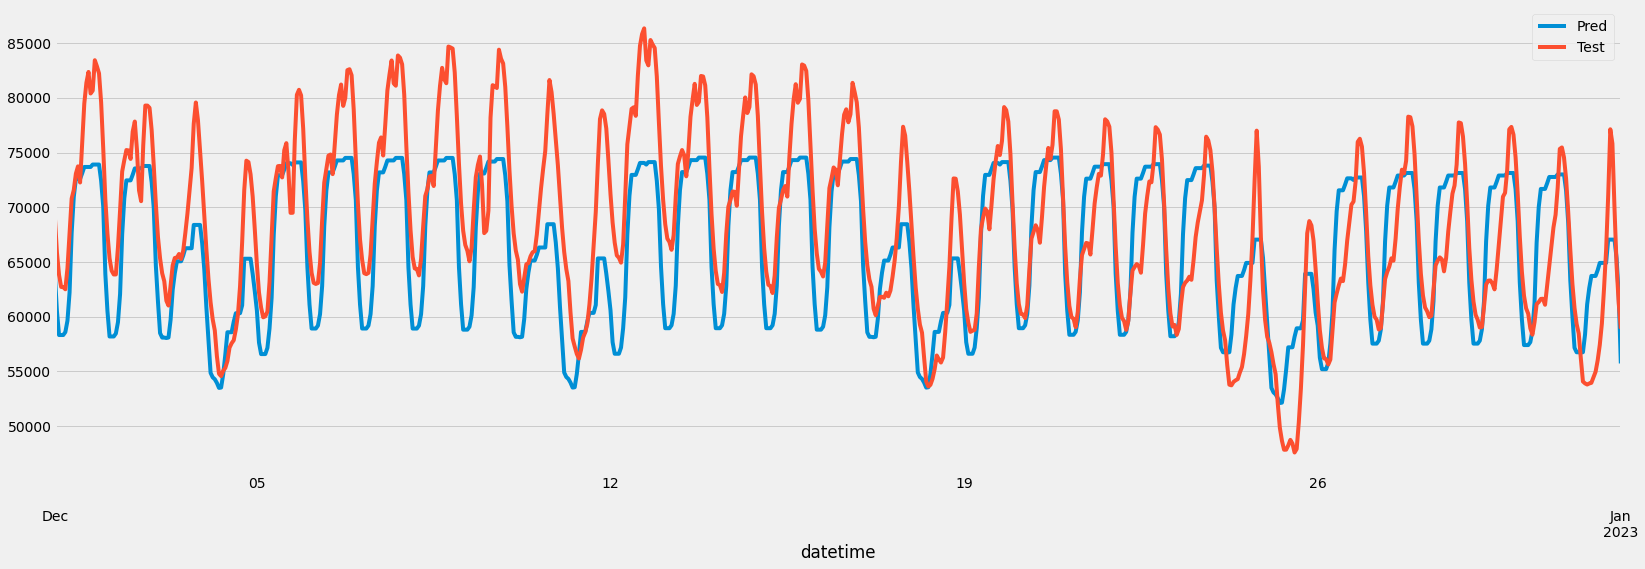

In [ ]:
df_test_cv = df.loc[df.index >= '2022-12-01']
df_test_cv['pred'] = preds[-1][-df_test_cv.shape[0]:]

fig, ax = plt.subplots(figsize = (25, 8))

df_test_cv['pred'].plot(ax=ax)
# df_test['pred_with_lag'].plot(ax=ax)
df_test_cv['hourly_demand'].plot(ax=ax)

ax.legend(['Pred', 'Test'])
plt.show()

**Итоги**:

*   Провели разведовательный анализ данных, шде обнаружили один выброс
*   Использовали две стратегии разбивки данных на трейн и тест (классическая разбивка и cross validation) с учетом того что были представленны временные ряды
*   Добавили новые признаки в данные. Извлекли из временных рядов часы, число, месяц, год, а также дни недели
*   Также создали ***Lag Features***. То есть данные о таргете за прошлый период. К сожалению, эти данные только ухудшали предсказания модели, поэтому в итоговую модель их не включили. Причиной может служить то, что данные носят сезонно-линейный характер, и поэтому результаты прошлых лет могли занижать предсказания. В целом неплохой прием, который можно применять при анализе временных рядов.
*   Получен практический опыт в работе с временными рядами, в создании новых признаков и в обучении модели ***xgboost***







